# EUGuessr

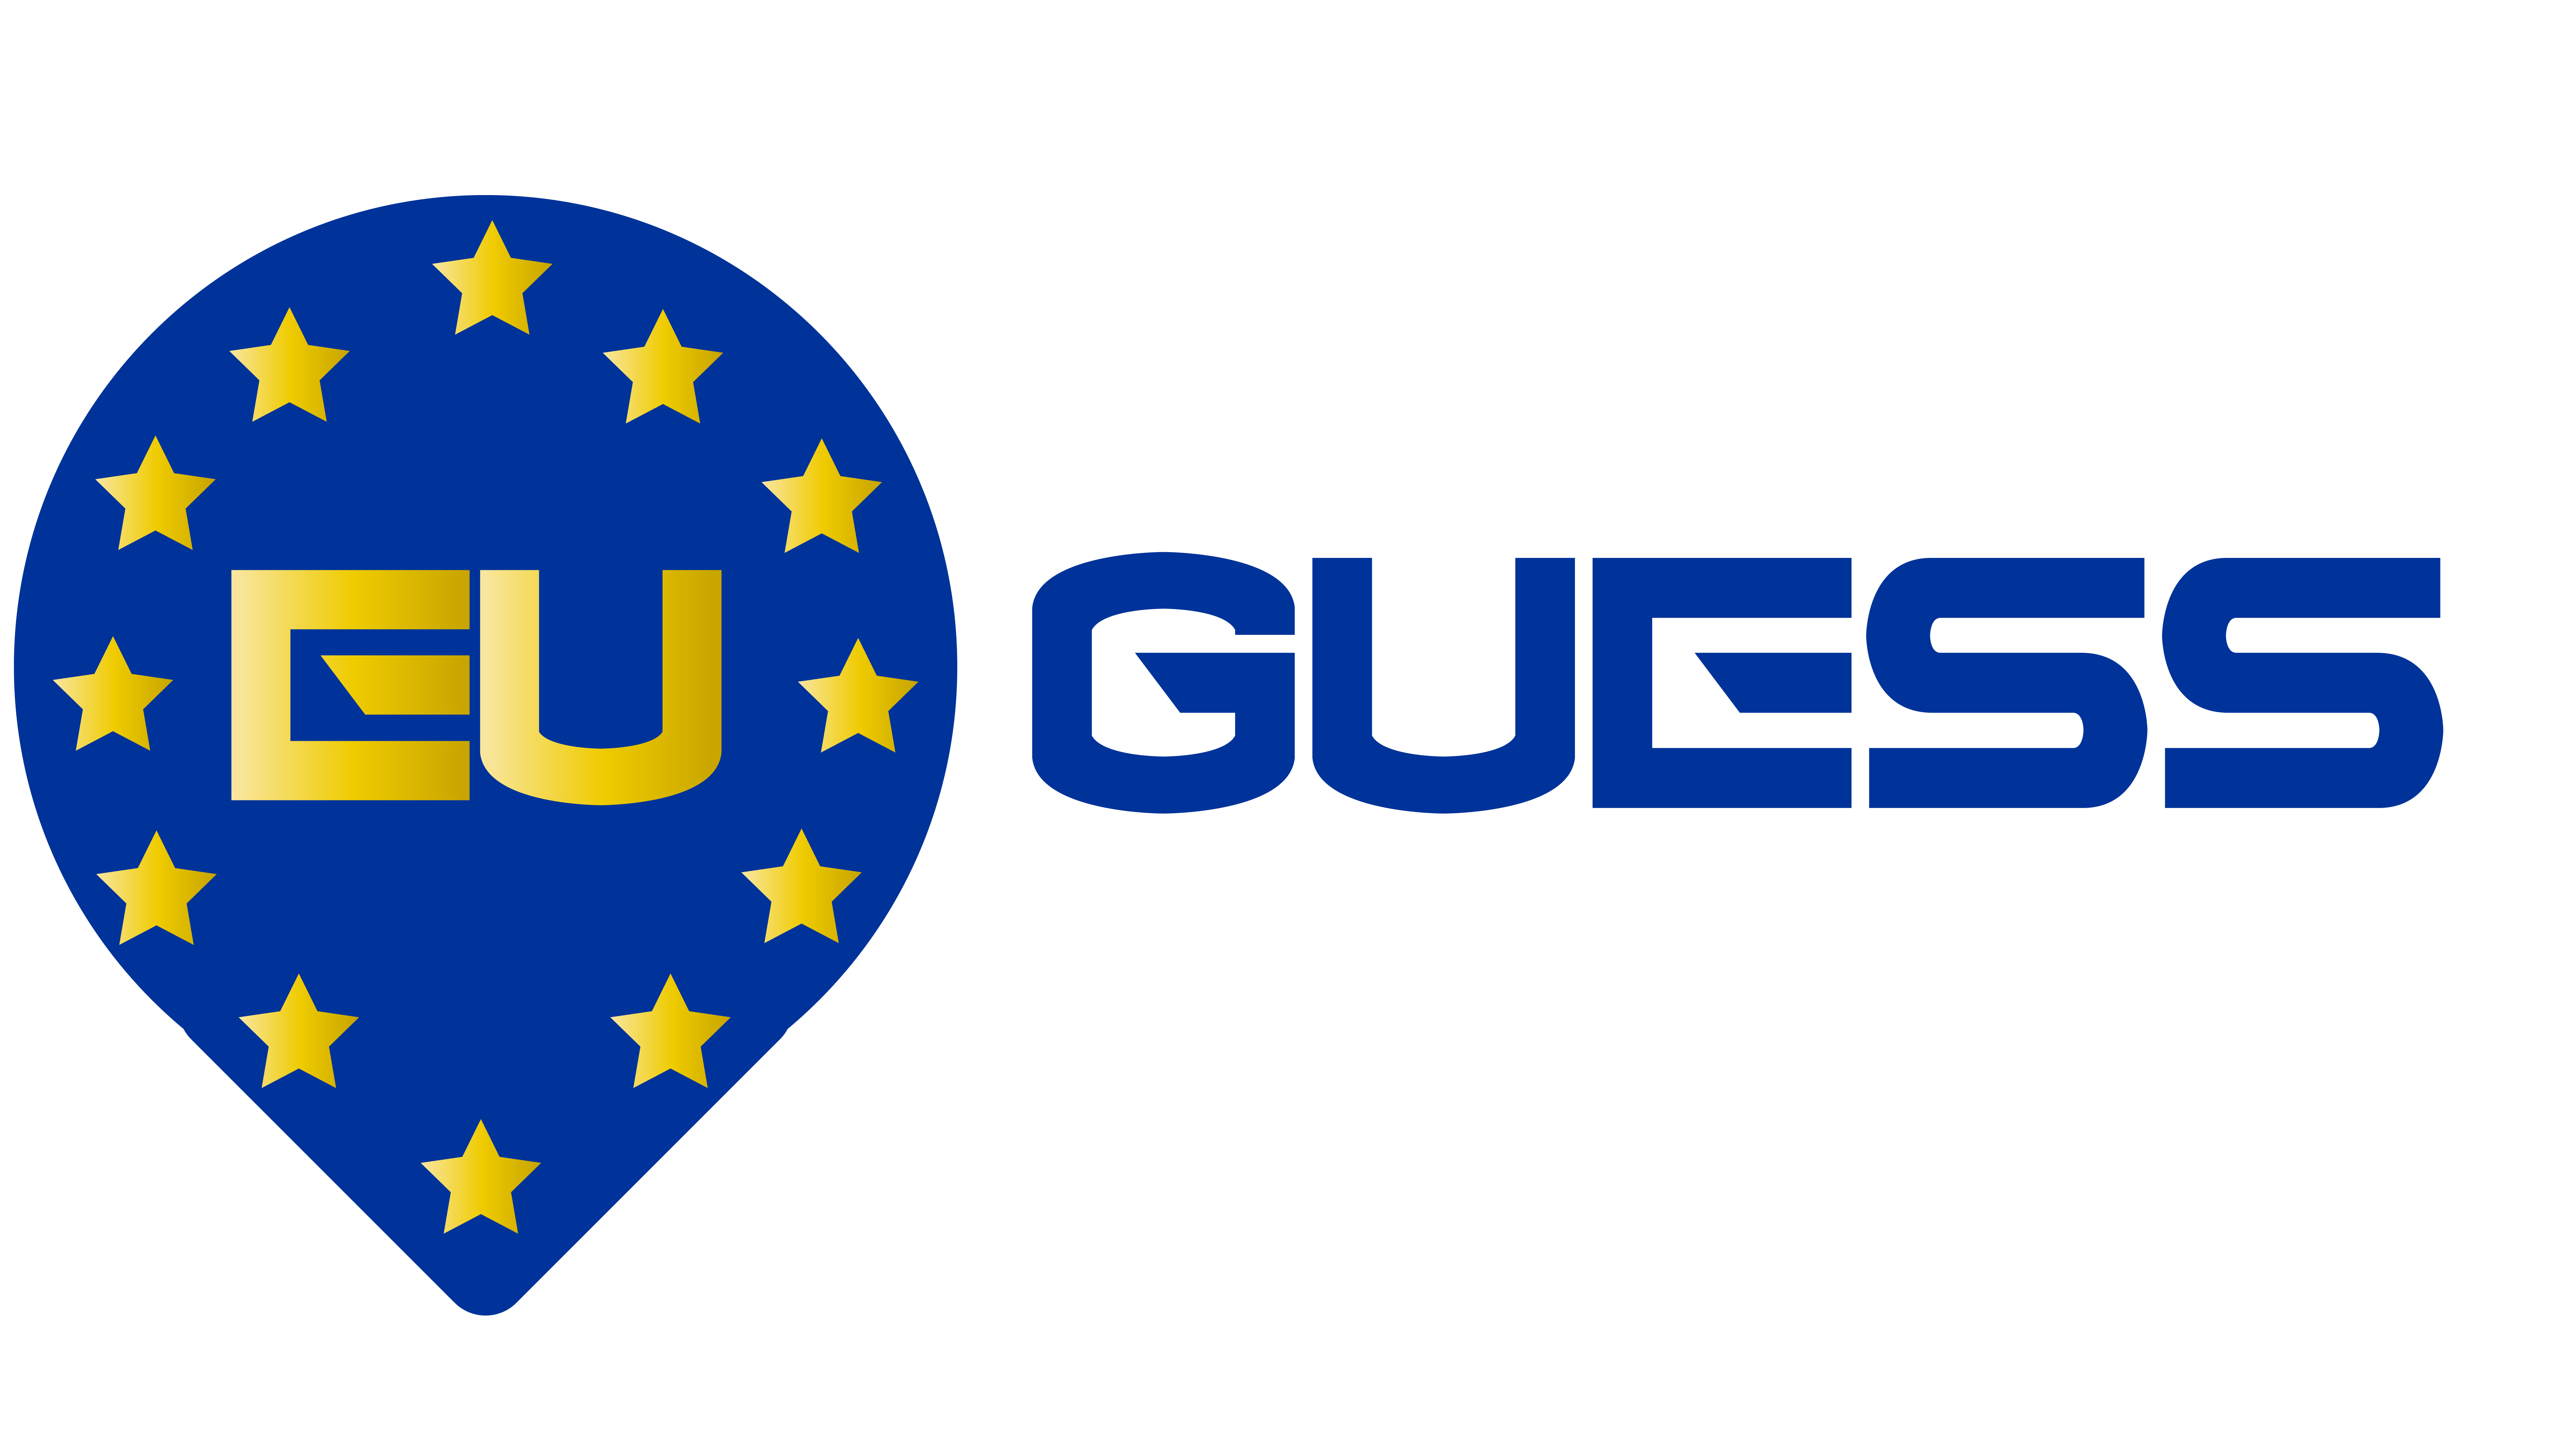

# Initialization:

Connect your Google Drive with Colab in order to set up the environment. Run the following cells and make sure the path is correct:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/EUGUESS

# Main:

## Generate Dataset:

Run the next cell to generate the dataset for training the model. If models are already trained, please do not execute.

In [ ]:
#! python generateDataset.py

## Resize Images:

Running this cell you will resize any image to the desired pixels. Run only if necessary. See **utils.py** for more information.

In [ ]:
from utils import image_to_tensor_resize, resize_image, resize_images
import os


os.chdir("/content/drive/MyDrive/GEOMODEL/GAME")


#resize_images(pixels=64)
resize_images(pixels=64)

ModuleNotFoundError: ignored

## Save Tensors:

This cell takes images and convert to tensors. See **utils.py** for more information.

In [ ]:
from utils import save_tensors

save_tensors(pixels=64)

100%|██████████| 33929/33929 [2:22:10<00:00,  3.98it/s]


## Load Dataset:

By running this cell you will load the dataset to train the models.  See **utils.py** for more information.

In [ ]:
data = [0]*42773
labels = [0]*42773
join = [0]*42773

In [ ]:
from utils import load_data, load_tensors

#data, labels, join_data = load_data(data, labels, join, pixels=128)
data, labels, join_data = load_tensors(data, labels, join)


['/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_0_0.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_0_1.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_0_2.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_100_0.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_100_1.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_100_2.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_101_0.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_101_1.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_101_2.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_102_0.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_102_1.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_102_2.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_103_0.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_103_1.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_103_2.t', '/content/drive/MyDrive/GEOMODEL/ALL_TENSORS/Albania_104_0.t

100%|██████████| 42773/42773 [00:46<00:00, 924.62it/s] 
/content/drive/.shortcut-targets-by-id/1PBjdDK97Px6Fd964O7_bQqLbWq9q_J1e/GEOMODEL/utils.py:268: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(data), torch.tensor(labels), np.array(join)
/content/drive/.shortcut-targets-by-id/1PBjdDK97Px6Fd964O7_bQqLbWq9q_J1e/GEOMODEL/utils.py:268: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=objec

In [ ]:
print(join_data.shape)

(42773,)


In [ ]:
print(data[5], labels[5])
print(data[5].shape)

## Split Dataset:

In this cell you are going to split the aboved dataset into train and test and you can choose the number of perspectives. See **utils.py** for more information.

In [ ]:
perspectives = '3' #@param ["1", "2", "3"]
proportion_train_test = 0.8 #@param {type:"slider", min:0.5, max:1, step:0.05}


# ---------------------------------------------------
from utils import split_one_perspective, split_two_perspective, split_three_perspective, split_train_test

idx = list(range(0, len(data)))

train, test, labels_train, labels_test = split_train_test(idx, data, labels, perspectives, proportion_train_test)


In [ ]:
print(train.shape)

(34219,)


In [ ]:
print(train[0], labels_train[0])
print(train[0].reshape(640, 640, 3))

## Train:

In this section you will choose parameters and models to train. See **utils.py** for more information.

In [ ]:
pixels = 64 #@param {type:"integer"}
batch_size = 1000 #@param {type:"integer"}
num_epochs = 10 #@param {type:"slider", min:0, max:20, step:1}
learning_rate = 0.0005 #@param {type:"number"}
momentum = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models

In [ ]:
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)


### CustomNet 1:

In [ ]:
n_classes = len(np.unique(labels))
 
class CustomNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, pixels, kernel_size=7, stride=2, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(pixels, pixels, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(pixels, 128, kernel_size=5, padding='same')
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, padding='same')
        self.conv5 = nn.Conv2d(128, 256, kernel_size=5, padding='same')
        self.conv6 = nn.Conv2d(256, 256, kernel_size=5, padding='same')
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, n_classes)
        self.bn1 = nn.BatchNorm2d(pixels)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.drop = nn.Dropout(p=0.7)
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bn1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.bn2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.bn3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x
 
 
net = CustomNet1()

### CustomNet 2:

In [ ]:
n_classes = len(np.unique(labels))

class CustomNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, pixels, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(pixels, pixels, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(pixels, 128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, padding='same')
        self.conv5 = nn.Conv2d(128, batch_size, kernel_size=5, padding=1)
        self.conv6 = nn.Conv2d(batch_size, batch_size, kernel_size=5, padding='same')
        self.fc1 = nn.LazyLinear(64)
        self.fc2 = nn.Linear(64, n_classes)
        self.bn1 = nn.BatchNorm2d(pixels)
        self.bn3 = nn.BatchNorm2d(batch_size)
        self.bn2 = nn.BatchNorm2d(128)
        self.drop = nn.Dropout(p=0.7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.bn3(x)
        x = self.pool(F.relu(self.conv6(x)))
        x = self.bn3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)

        return x


net = CustomNet2()

### EfficientNet B4:

In [ ]:
def efficientnet_model():

    model = models.efficientnet_b4(pretrained=True, progress=True)
    model.eval()
    return model

net = efficientnet_model()

### VGG/16:

In [ ]:
def VGG_model():

    model = models.vgg16(pretrained=True, progress=True)
    model.eval()
    return model

net = VGG_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### ResNet50:

In [ ]:
def resnet50_model():
  
    model = models.resnet50(pretrained=False, progress=True)

    model.eval()
    return model

net = resnet50_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### GoogleNet:

In [ ]:
def googlenet_model():

    model = models.googlenet(pretrained=True, progress=True)

    model.eval()
    return model

net = googlenet_model()

### Training:

In [ ]:
import torch.optim as optim
import tensorflow as tf

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.01, last_epoch=-1)

In [ ]:
from utils import one_hot_labels, accuracy
from tqdm import tqdm


for epoch in range(num_epochs):

    running_loss = 0.0
    acc = 0.0
    for i, (data) in tqdm(enumerate(trainloader)):

        # get the inputs:
        inputs = data

        # zero gradients
        optimizer.zero_grad()

        # forward:
        outputs = net(inputs)

        # backward:
        loss = criterion(outputs, labels_train[i*batch_size:i*batch_size+batch_size])
        loss.backward()

        # optimizer:
        optimizer.step()

        batch_acc = accuracy(outputs, labels_train[i*batch_size:i*batch_size+batch_size])
        print(' Accuracy:', batch_acc)
        running_loss += loss.item()
        acc += batch_acc
        
    scheduler.step()

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (len(train)/batch_size):.3f}')
    print(f'[{epoch + 1}, {i + 1:5d}] acc: {acc / (len(train)/batch_size):.3f}')
    running_loss = 0.0

print('Finished Training')

1it [00:04,  4.47s/it]

 Accuracy: 0.026


2it [00:08,  4.42s/it]

 Accuracy: 0.031


3it [00:13,  4.40s/it]

 Accuracy: 0.032


4it [00:17,  4.37s/it]

 Accuracy: 0.038


5it [00:21,  4.38s/it]

 Accuracy: 0.037


6it [00:26,  4.37s/it]

 Accuracy: 0.042


7it [00:30,  4.36s/it]

 Accuracy: 0.036


8it [00:35,  4.44s/it]

 Accuracy: 0.036


9it [00:41,  4.93s/it]

 Accuracy: 0.032


10it [00:45,  4.87s/it]

 Accuracy: 0.038


11it [00:50,  4.73s/it]

 Accuracy: 0.029


12it [00:54,  4.64s/it]

 Accuracy: 0.045


13it [00:59,  4.55s/it]

 Accuracy: 0.051


14it [01:03,  4.48s/it]

 Accuracy: 0.048


15it [01:07,  4.45s/it]

 Accuracy: 0.052


16it [01:12,  4.42s/it]

 Accuracy: 0.038


17it [01:16,  4.39s/it]

 Accuracy: 0.034


18it [01:20,  4.36s/it]

 Accuracy: 0.048


19it [01:25,  4.36s/it]

 Accuracy: 0.048


20it [01:29,  4.35s/it]

 Accuracy: 0.036


21it [01:33,  4.36s/it]

 Accuracy: 0.046


22it [01:38,  4.37s/it]

 Accuracy: 0.053


23it [01:42,  4.38s/it]

 Accuracy: 0.049


24it [01:47,  4.36s/it]

 Accuracy: 0.049


25it [01:51,  4.35s/it]

 Accuracy: 0.052


26it [01:55,  4.34s/it]

 Accuracy: 0.059


27it [01:59,  4.33s/it]

 Accuracy: 0.06


28it [02:04,  4.36s/it]

 Accuracy: 0.06


29it [02:09,  4.55s/it]

 Accuracy: 0.047


30it [02:13,  4.49s/it]

 Accuracy: 0.06


31it [02:18,  4.45s/it]

 Accuracy: 0.054


32it [02:22,  4.41s/it]

 Accuracy: 0.059


33it [02:26,  4.38s/it]

 Accuracy: 0.064


34it [02:31,  4.36s/it]

 Accuracy: 0.051


35it [02:32,  4.34s/it]


 Accuracy: 0.04128440366972477
[1,    35] loss: 3.560
[1,    35] acc: 0.046


1it [00:04,  4.34s/it]

 Accuracy: 0.061


2it [00:08,  4.30s/it]

 Accuracy: 0.067


3it [00:12,  4.31s/it]

 Accuracy: 0.048


4it [00:17,  4.33s/it]

 Accuracy: 0.066


5it [00:21,  4.31s/it]

 Accuracy: 0.067


6it [00:25,  4.33s/it]

 Accuracy: 0.054


7it [00:30,  4.33s/it]

 Accuracy: 0.078


8it [00:34,  4.33s/it]

 Accuracy: 0.055


9it [00:38,  4.34s/it]

 Accuracy: 0.062


10it [00:43,  4.34s/it]

 Accuracy: 0.074


11it [00:47,  4.33s/it]

 Accuracy: 0.067


12it [00:51,  4.33s/it]

 Accuracy: 0.064


13it [00:56,  4.31s/it]

 Accuracy: 0.071


14it [01:00,  4.32s/it]

 Accuracy: 0.078


15it [01:04,  4.32s/it]

 Accuracy: 0.074


16it [01:09,  4.32s/it]

 Accuracy: 0.06


17it [01:13,  4.32s/it]

 Accuracy: 0.068


18it [01:17,  4.32s/it]

 Accuracy: 0.085


19it [01:22,  4.31s/it]

 Accuracy: 0.058


20it [01:26,  4.30s/it]

 Accuracy: 0.062


21it [01:30,  4.32s/it]

 Accuracy: 0.087


22it [01:35,  4.32s/it]

 Accuracy: 0.065


23it [01:39,  4.36s/it]

 Accuracy: 0.074


24it [01:43,  4.36s/it]

 Accuracy: 0.068


25it [01:48,  4.34s/it]

 Accuracy: 0.07


26it [01:52,  4.35s/it]

 Accuracy: 0.068


27it [01:56,  4.37s/it]

 Accuracy: 0.087


28it [02:01,  4.36s/it]

 Accuracy: 0.079


29it [02:05,  4.35s/it]

 Accuracy: 0.084


30it [02:10,  4.38s/it]

 Accuracy: 0.098


31it [02:14,  4.41s/it]

 Accuracy: 0.085


32it [02:19,  4.43s/it]

 Accuracy: 0.08


33it [02:23,  4.45s/it]

 Accuracy: 0.077


34it [02:28,  4.45s/it]

 Accuracy: 0.073


35it [02:29,  4.26s/it]


 Accuracy: 0.10091743119266056
[2,    35] loss: 3.465
[2,    35] acc: 0.073


1it [00:04,  4.56s/it]

 Accuracy: 0.096


2it [00:09,  4.52s/it]

 Accuracy: 0.11


3it [00:13,  4.47s/it]

 Accuracy: 0.073


4it [00:17,  4.45s/it]

 Accuracy: 0.085


5it [00:22,  4.41s/it]

 Accuracy: 0.095


6it [00:26,  4.39s/it]

 Accuracy: 0.102


7it [00:30,  4.40s/it]

 Accuracy: 0.098


8it [00:35,  4.38s/it]

 Accuracy: 0.081


9it [00:39,  4.38s/it]

 Accuracy: 0.068


10it [00:44,  4.37s/it]

 Accuracy: 0.097


11it [00:48,  4.38s/it]

 Accuracy: 0.085


12it [00:52,  4.38s/it]

 Accuracy: 0.097


13it [00:57,  4.37s/it]

 Accuracy: 0.083


14it [01:01,  4.37s/it]

 Accuracy: 0.102


15it [01:06,  4.39s/it]

 Accuracy: 0.086


16it [01:10,  4.41s/it]

 Accuracy: 0.083


17it [01:15,  4.48s/it]

 Accuracy: 0.086


18it [01:19,  4.45s/it]

 Accuracy: 0.097


19it [01:23,  4.41s/it]

 Accuracy: 0.089


20it [01:28,  4.39s/it]

 Accuracy: 0.085


21it [01:32,  4.38s/it]

 Accuracy: 0.093


22it [01:36,  4.40s/it]

 Accuracy: 0.097


23it [01:41,  4.40s/it]

 Accuracy: 0.1


24it [01:45,  4.42s/it]

 Accuracy: 0.096


25it [01:50,  4.40s/it]

 Accuracy: 0.114


26it [01:54,  4.39s/it]

 Accuracy: 0.091


27it [01:58,  4.39s/it]

 Accuracy: 0.096


28it [02:03,  4.39s/it]

 Accuracy: 0.103


29it [02:07,  4.40s/it]

 Accuracy: 0.103


30it [02:12,  4.41s/it]

 Accuracy: 0.105


31it [02:16,  4.41s/it]

 Accuracy: 0.112


32it [02:20,  4.41s/it]

 Accuracy: 0.104


33it [02:25,  4.42s/it]

 Accuracy: 0.093


34it [02:29,  4.43s/it]

 Accuracy: 0.115


35it [02:30,  4.31s/it]


 Accuracy: 0.1651376146788991
[3,    35] loss: 3.398
[3,    35] acc: 0.099


1it [00:04,  4.43s/it]

 Accuracy: 0.112


2it [00:08,  4.43s/it]

 Accuracy: 0.112


3it [00:13,  4.40s/it]

 Accuracy: 0.082


4it [00:17,  4.39s/it]

 Accuracy: 0.119


5it [00:22,  4.47s/it]

 Accuracy: 0.096


6it [00:27,  4.68s/it]

 Accuracy: 0.104


7it [00:32,  4.86s/it]

 Accuracy: 0.104


8it [00:37,  4.96s/it]

 Accuracy: 0.112


9it [00:42,  5.03s/it]

 Accuracy: 0.098


10it [00:48,  5.06s/it]

 Accuracy: 0.107


11it [00:52,  4.96s/it]

 Accuracy: 0.112


12it [00:57,  4.98s/it]

 Accuracy: 0.11


13it [01:02,  5.03s/it]

 Accuracy: 0.104


14it [01:08,  5.11s/it]

 Accuracy: 0.125


15it [01:13,  5.12s/it]

 Accuracy: 0.103


16it [01:18,  5.10s/it]

 Accuracy: 0.113


17it [01:23,  5.12s/it]

 Accuracy: 0.113


18it [01:28,  5.17s/it]

 Accuracy: 0.117


19it [01:34,  5.19s/it]

 Accuracy: 0.098


20it [01:39,  5.19s/it]

 Accuracy: 0.101


21it [01:44,  5.18s/it]

 Accuracy: 0.116


22it [01:49,  5.18s/it]

 Accuracy: 0.115


23it [01:54,  5.19s/it]

 Accuracy: 0.107


24it [02:00,  5.20s/it]

 Accuracy: 0.103


25it [02:05,  5.22s/it]

 Accuracy: 0.122


26it [02:10,  5.23s/it]

 Accuracy: 0.128


27it [02:15,  5.24s/it]

 Accuracy: 0.114


28it [02:21,  5.22s/it]

 Accuracy: 0.124


29it [02:26,  5.23s/it]

 Accuracy: 0.108


30it [02:31,  5.21s/it]

 Accuracy: 0.127


31it [02:36,  5.22s/it]

 Accuracy: 0.129


32it [02:41,  5.22s/it]

 Accuracy: 0.126


33it [02:47,  5.21s/it]

 Accuracy: 0.116


34it [02:52,  5.21s/it]

 Accuracy: 0.117


35it [02:53,  4.96s/it]


 Accuracy: 0.14220183486238533
[4,    35] loss: 3.341
[4,    35] acc: 0.115


1it [00:05,  5.44s/it]

 Accuracy: 0.122


2it [00:10,  5.38s/it]

 Accuracy: 0.138


3it [00:16,  5.32s/it]

 Accuracy: 0.114


4it [00:21,  5.24s/it]

 Accuracy: 0.119


5it [00:26,  5.19s/it]

 Accuracy: 0.12


6it [00:31,  5.21s/it]

 Accuracy: 0.119


7it [00:36,  5.25s/it]

 Accuracy: 0.127


8it [00:42,  5.23s/it]

 Accuracy: 0.123


9it [00:47,  5.23s/it]

 Accuracy: 0.121


10it [00:52,  5.21s/it]

 Accuracy: 0.111


11it [00:57,  5.19s/it]

 Accuracy: 0.124


12it [01:02,  5.19s/it]

 Accuracy: 0.114


13it [01:07,  5.20s/it]

 Accuracy: 0.12


14it [01:13,  5.24s/it]

 Accuracy: 0.109


15it [01:18,  5.22s/it]

 Accuracy: 0.135


16it [01:23,  5.23s/it]

 Accuracy: 0.133


17it [01:28,  5.22s/it]

 Accuracy: 0.129


18it [01:34,  5.29s/it]

 Accuracy: 0.128


19it [01:39,  5.31s/it]

 Accuracy: 0.13


20it [01:44,  5.27s/it]

 Accuracy: 0.116


21it [01:50,  5.26s/it]

 Accuracy: 0.133


22it [01:55,  5.26s/it]

 Accuracy: 0.117


23it [02:00,  5.23s/it]

 Accuracy: 0.115


24it [02:05,  5.19s/it]

 Accuracy: 0.118


25it [02:10,  5.23s/it]

 Accuracy: 0.127


26it [02:16,  5.19s/it]

 Accuracy: 0.117


27it [02:21,  5.17s/it]

 Accuracy: 0.131


28it [02:26,  5.24s/it]

 Accuracy: 0.133


29it [02:31,  5.24s/it]

 Accuracy: 0.142


30it [02:37,  5.24s/it]

 Accuracy: 0.144


31it [02:42,  5.22s/it]

 Accuracy: 0.152


32it [02:47,  5.22s/it]

 Accuracy: 0.14


33it [02:52,  5.25s/it]

 Accuracy: 0.144


34it [02:58,  5.27s/it]

 Accuracy: 0.137


35it [02:59,  5.12s/it]


 Accuracy: 0.18807339449541285
[5,    35] loss: 3.286
[5,    35] acc: 0.131


1it [00:05,  5.18s/it]

 Accuracy: 0.128


2it [00:10,  5.18s/it]

 Accuracy: 0.139


3it [00:15,  5.15s/it]

 Accuracy: 0.124


4it [00:20,  5.16s/it]

 Accuracy: 0.133


5it [00:25,  5.16s/it]

 Accuracy: 0.139


6it [00:30,  5.15s/it]

 Accuracy: 0.12


7it [00:35,  5.12s/it]

 Accuracy: 0.14


8it [00:41,  5.13s/it]

 Accuracy: 0.129


9it [00:46,  5.18s/it]

 Accuracy: 0.118


10it [00:51,  5.16s/it]

 Accuracy: 0.12


11it [00:56,  5.17s/it]

 Accuracy: 0.146


12it [01:01,  5.15s/it]

 Accuracy: 0.124


13it [01:07,  5.17s/it]

 Accuracy: 0.135


14it [01:12,  5.24s/it]

 Accuracy: 0.129


15it [01:17,  5.23s/it]

 Accuracy: 0.128


16it [01:22,  5.24s/it]

 Accuracy: 0.145


17it [01:28,  5.27s/it]

 Accuracy: 0.154


18it [01:33,  5.26s/it]

 Accuracy: 0.124


19it [01:38,  5.27s/it]

 Accuracy: 0.125


20it [01:44,  5.25s/it]

 Accuracy: 0.132


21it [01:49,  5.31s/it]

 Accuracy: 0.139


22it [01:54,  5.31s/it]

 Accuracy: 0.127


23it [02:00,  5.31s/it]

 Accuracy: 0.15


24it [02:05,  5.22s/it]

 Accuracy: 0.124


25it [02:10,  5.13s/it]

 Accuracy: 0.146


26it [02:14,  5.02s/it]

 Accuracy: 0.135


27it [02:20,  5.09s/it]

 Accuracy: 0.149


28it [02:25,  5.07s/it]

 Accuracy: 0.144


29it [02:30,  5.06s/it]

 Accuracy: 0.146


30it [02:34,  4.96s/it]

 Accuracy: 0.146


31it [02:39,  4.96s/it]

 Accuracy: 0.152


32it [02:44,  4.97s/it]

 Accuracy: 0.157


33it [02:49,  5.00s/it]

 Accuracy: 0.139


34it [02:54,  5.05s/it]

 Accuracy: 0.138


35it [02:56,  5.03s/it]


 Accuracy: 0.18807339449541285
[6,    35] loss: 3.231
[6,    35] acc: 0.141


1it [00:04,  4.84s/it]

 Accuracy: 0.14


2it [00:09,  4.96s/it]

 Accuracy: 0.152


3it [00:14,  4.97s/it]

 Accuracy: 0.141


4it [00:20,  5.05s/it]

 Accuracy: 0.137


5it [00:25,  5.11s/it]

 Accuracy: 0.139


6it [00:30,  5.16s/it]

 Accuracy: 0.152


7it [00:35,  5.22s/it]

 Accuracy: 0.132


8it [00:41,  5.30s/it]

 Accuracy: 0.142


9it [00:46,  5.41s/it]

 Accuracy: 0.133


10it [00:52,  5.56s/it]

 Accuracy: 0.125


11it [00:58,  5.51s/it]

 Accuracy: 0.152


12it [01:03,  5.49s/it]

 Accuracy: 0.158


13it [01:09,  5.53s/it]

 Accuracy: 0.132


14it [01:14,  5.52s/it]

 Accuracy: 0.142


15it [01:20,  5.51s/it]

 Accuracy: 0.159


16it [01:25,  5.49s/it]

 Accuracy: 0.139


17it [01:30,  5.38s/it]

 Accuracy: 0.153


18it [01:35,  5.29s/it]

 Accuracy: 0.139


19it [01:41,  5.22s/it]

 Accuracy: 0.129


20it [01:45,  5.12s/it]

 Accuracy: 0.146


21it [01:50,  5.01s/it]

 Accuracy: 0.134


22it [01:55,  4.87s/it]

 Accuracy: 0.135


23it [01:59,  4.79s/it]

 Accuracy: 0.139


24it [02:04,  4.72s/it]

 Accuracy: 0.13


25it [02:08,  4.66s/it]

 Accuracy: 0.169


26it [02:13,  4.63s/it]

 Accuracy: 0.149


27it [02:18,  4.63s/it]

 Accuracy: 0.155


28it [02:22,  4.63s/it]

 Accuracy: 0.151


29it [02:27,  4.62s/it]

 Accuracy: 0.165


30it [02:31,  4.54s/it]

 Accuracy: 0.154


31it [02:36,  4.51s/it]

 Accuracy: 0.162


32it [02:40,  4.52s/it]

 Accuracy: 0.173


33it [02:44,  4.47s/it]

 Accuracy: 0.144


34it [02:49,  4.48s/it]

 Accuracy: 0.155


35it [02:50,  4.88s/it]


 Accuracy: 0.2981651376146789
[7,    35] loss: 3.181
[7,    35] acc: 0.154


1it [00:05,  5.51s/it]

 Accuracy: 0.164


2it [00:10,  5.11s/it]

 Accuracy: 0.177


3it [00:15,  5.11s/it]

 Accuracy: 0.154


4it [00:20,  5.18s/it]

 Accuracy: 0.155


5it [00:25,  5.08s/it]

 Accuracy: 0.152


6it [00:31,  5.19s/it]

 Accuracy: 0.167


7it [00:36,  5.28s/it]

 Accuracy: 0.153


8it [00:41,  5.30s/it]

 Accuracy: 0.144


9it [00:47,  5.33s/it]

 Accuracy: 0.165


10it [00:52,  5.32s/it]

 Accuracy: 0.147


11it [00:57,  5.11s/it]

 Accuracy: 0.157


12it [01:01,  4.93s/it]

 Accuracy: 0.164


13it [01:06,  4.82s/it]

 Accuracy: 0.174


14it [01:10,  4.71s/it]

 Accuracy: 0.145


15it [01:15,  4.61s/it]

 Accuracy: 0.171


16it [01:19,  4.56s/it]

 Accuracy: 0.152


17it [01:24,  4.54s/it]

 Accuracy: 0.166


18it [01:28,  4.50s/it]

 Accuracy: 0.168


19it [01:33,  4.60s/it]

 Accuracy: 0.147


20it [01:38,  4.71s/it]

 Accuracy: 0.157


21it [01:42,  4.60s/it]

 Accuracy: 0.175


22it [01:47,  4.56s/it]

 Accuracy: 0.14


23it [01:51,  4.50s/it]

 Accuracy: 0.14


24it [01:55,  4.47s/it]

 Accuracy: 0.154


25it [02:00,  4.65s/it]

 Accuracy: 0.164


26it [02:05,  4.69s/it]

 Accuracy: 0.153


27it [02:10,  4.83s/it]

 Accuracy: 0.16


28it [02:15,  4.92s/it]

 Accuracy: 0.163


29it [02:21,  4.98s/it]

 Accuracy: 0.173


30it [02:26,  5.05s/it]

 Accuracy: 0.186


31it [02:31,  5.11s/it]

 Accuracy: 0.188


32it [02:37,  5.22s/it]

 Accuracy: 0.194


33it [02:42,  5.20s/it]

 Accuracy: 0.166


34it [02:47,  5.15s/it]

 Accuracy: 0.155


35it [02:48,  4.81s/it]


 Accuracy: 0.26605504587155965
[8,    35] loss: 3.117
[8,    35] acc: 0.168


1it [00:05,  5.17s/it]

 Accuracy: 0.178


2it [00:10,  5.27s/it]

 Accuracy: 0.183


3it [00:15,  5.33s/it]

 Accuracy: 0.168


4it [00:21,  5.37s/it]

 Accuracy: 0.178


5it [00:26,  5.34s/it]

 Accuracy: 0.168


6it [00:32,  5.37s/it]

 Accuracy: 0.167


7it [00:37,  5.41s/it]

 Accuracy: 0.154


8it [00:43,  5.52s/it]

 Accuracy: 0.159


9it [00:48,  5.55s/it]

 Accuracy: 0.169


10it [00:54,  5.55s/it]

 Accuracy: 0.164


11it [00:59,  5.54s/it]

 Accuracy: 0.177


12it [01:05,  5.52s/it]

 Accuracy: 0.16


13it [01:10,  5.51s/it]

 Accuracy: 0.178


14it [01:16,  5.45s/it]

 Accuracy: 0.164


15it [01:21,  5.43s/it]

 Accuracy: 0.179


16it [01:26,  5.34s/it]

 Accuracy: 0.166


17it [01:31,  5.21s/it]

 Accuracy: 0.19


18it [01:36,  5.11s/it]

 Accuracy: 0.201


19it [01:41,  5.00s/it]

 Accuracy: 0.162


20it [01:46,  5.04s/it]

 Accuracy: 0.159


21it [01:51,  5.04s/it]

 Accuracy: 0.163


22it [01:56,  5.12s/it]

 Accuracy: 0.186


23it [02:01,  5.12s/it]

 Accuracy: 0.169


24it [02:06,  5.06s/it]

 Accuracy: 0.184


25it [02:12,  5.10s/it]

 Accuracy: 0.175


26it [02:17,  5.22s/it]

 Accuracy: 0.169


27it [02:23,  5.36s/it]

 Accuracy: 0.154


28it [02:27,  5.18s/it]

 Accuracy: 0.177


29it [02:32,  5.03s/it]

 Accuracy: 0.202


30it [02:37,  5.04s/it]

 Accuracy: 0.185


31it [02:42,  5.06s/it]

 Accuracy: 0.196


32it [02:47,  4.95s/it]

 Accuracy: 0.195


33it [02:51,  4.79s/it]

 Accuracy: 0.155


34it [02:56,  4.73s/it]

 Accuracy: 0.18


35it [02:57,  5.07s/it]


 Accuracy: 0.2981651376146789
[9,    35] loss: 3.061
[9,    35] acc: 0.182


1it [00:04,  4.46s/it]

 Accuracy: 0.185


2it [00:08,  4.42s/it]

 Accuracy: 0.186


3it [00:13,  4.41s/it]

 Accuracy: 0.161


4it [00:17,  4.39s/it]

 Accuracy: 0.188


5it [00:22,  4.40s/it]

 Accuracy: 0.182


6it [00:26,  4.39s/it]

 Accuracy: 0.2


7it [00:30,  4.40s/it]

 Accuracy: 0.184


8it [00:35,  4.37s/it]

 Accuracy: 0.184


9it [00:39,  4.36s/it]

 Accuracy: 0.168


10it [00:43,  4.37s/it]

 Accuracy: 0.161


11it [00:48,  4.37s/it]

 Accuracy: 0.182


12it [00:52,  4.37s/it]

 Accuracy: 0.179


13it [00:57,  4.44s/it]

 Accuracy: 0.187


14it [01:01,  4.51s/it]

 Accuracy: 0.178


15it [01:06,  4.67s/it]

 Accuracy: 0.197


16it [01:11,  4.73s/it]

 Accuracy: 0.186


17it [01:16,  4.76s/it]

 Accuracy: 0.178


18it [01:21,  4.80s/it]

 Accuracy: 0.187


19it [01:26,  4.96s/it]

 Accuracy: 0.177


20it [01:32,  5.07s/it]

 Accuracy: 0.175


21it [01:37,  5.13s/it]

 Accuracy: 0.176


22it [01:42,  5.18s/it]

 Accuracy: 0.167


23it [01:47,  5.21s/it]

 Accuracy: 0.191


24it [01:53,  5.23s/it]

 Accuracy: 0.178


25it [01:58,  5.20s/it]

 Accuracy: 0.203


26it [02:03,  5.17s/it]

 Accuracy: 0.176


27it [02:08,  5.16s/it]

 Accuracy: 0.168


28it [02:13,  5.16s/it]

 Accuracy: 0.197


29it [02:19,  5.17s/it]

 Accuracy: 0.196


30it [02:24,  5.14s/it]

 Accuracy: 0.202


31it [02:29,  5.16s/it]

 Accuracy: 0.184


32it [02:34,  5.14s/it]

 Accuracy: 0.193


33it [02:39,  5.13s/it]

 Accuracy: 0.196


34it [02:44,  5.12s/it]

 Accuracy: 0.193


35it [02:45,  4.74s/it]

 Accuracy: 0.3669724770642202
[10,    35] loss: 2.994
[10,    35] acc: 0.193
Finished Training


## Test:

In this section you will test the model that you have run above:

In [ ]:
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [ ]:
acc = 0.0
for i, (data) in tqdm(enumerate(testloader)):

  inputs = data

  outputs = net(inputs)

  batch_acc = accuracy(outputs, labels_test[i*batch_size:i*batch_size+batch_size])
  print(' Accuracy:', batch_acc)
  acc += batch_acc

print("Accuracy:", acc/(len(test)/batch_size))

print('Finished Test')

1it [00:00,  1.10it/s]

 Accuracy: 0.156


2it [00:01,  1.02it/s]

 Accuracy: 0.179


3it [00:03,  1.03s/it]

 Accuracy: 0.149


4it [00:04,  1.02s/it]

 Accuracy: 0.149


5it [00:04,  1.02it/s]

 Accuracy: 0.146


6it [00:05,  1.03it/s]

 Accuracy: 0.158


7it [00:06,  1.05it/s]

 Accuracy: 0.16


8it [00:07,  1.08it/s]

 Accuracy: 0.171


9it [00:08,  1.10it/s]

 Accuracy: 0.15315315315315314
Accuracy: 0.1661195970956345
Finished Test


## Save Model:

Once you have tested the model, now it is time to save it. Be sure to include your path to store the model and a name, so you can differentiate it!

In [ ]:
model_save_name = 'your_model.pt'
path = F"your_path/{model_save_name}" 
torch.save(net.state_dict(), path)

## Load Model:

If you want to test any other model you can and later you can load the one you want with this cell. Make sure you have saved previously the model!

In [ ]:
model_save_name = 'your_model.pt'
path = F"your_path/{model_save_name}" 
net.load_state_dict(torch.load(path), strict=False)

### Countries:

In [ ]:
from utils import image_to_tensor_resize
import glob
import os
from tqdm import tqdm

data_country, labels_country, join_data_country = [0]*3291, [0]*3291, [0]*3291  

#files = sorted(glob.glob(f"/content/drive/MyDrive/GEOMODEL/IMAGES/DATASET/*jpg"))
files = sorted(glob.glob(f"/content/drive/MyDrive/GEOMODEL/GAME/*jpg"))

mapping = {"Albania": 0, "Austria": 1, "Belgium": 2, "Bosnia Herzegovina": 3, "Bulgaria": 4, "Croatia": 5, "Czech Republic": 6, "Denmark": 7, "Estonia": 8, "Finland": 9, "France": 10, "North Macedonia": 11, "Germany": 12, "Great Britain": 13, "Greece": 14, "Hungary": 15, "Italy": 16, "Latvia": 17, "Lithuania": 18, "Luxembourg": 19, "Montenegro": 20, "Netherlands": 21,  "Poland": 22, "Portugal": 23, "Romania": 24, "Serbia": 25, "Slovakia": 26, "Slovenia": 27, "Spain": 28, "Sweden": 29, "Switzerland": 30, "Turkey": 31} 
counter = {"Albania": 0, "Austria": 0, "Belgium": 0, "Bosnia Herzegovina": 0, "Bulgaria": 0, "Croatia": 0, "Czech Republic": 0, "Denmark": 0, "Estonia": 0, "Finland": 0, "France": 0, "North Macedonia": 0, "Germany": 0, "Great Britain": 0, "Greece": 0, "Hungary": 0, "Italy": 0, "Latvia": 0, "Lithuania": 0, "Luxembourg": 0, "Montenegro": 0, "Netherlands": 0,  "Poland": 0, "Portugal": 0, "Romania": 0, "Serbia": 0, "Slovakia": 0, "Slovenia": 0, "Spain": 0, "Sweden": 0, "Switzerland": 0, "Turkey": 0} 
i = 0
for file in tqdm(files): 
  img = os.path.split(file)[1]

  tensor = image_to_tensor_resize(img, 64) # funciona mejor con resize
  country = img.split("_")[0]
  
  data_country[i] = tensor
  labels_country[i] = mapping[country]
  tup = (tensor, mapping[country])
  join_data_country[i] = tup
  i += 1


  

100%|██████████| 3291/3291 [12:32<00:00,  4.37it/s]


In [ ]:
print(labels_country)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
labels_country = torch.tensor(labels_country)
data_country = np.array(data_country)

<ipython-input-99-38db8198b67d>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_country = np.array(data_country)
<ipython-input-99-38db8198b67d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_country = np.array(data_country)


In [ ]:
testloader = torch.utils.data.DataLoader(data_country, batch_size=3291,
                                         shuffle=False)

In [ ]:
from utils import accuracy
acc = 0.0
for i, (data) in tqdm(enumerate(testloader)):

  inputs = data
  #print(inputs)


  # forward + backward + optimize
  outputs = net(inputs)
  #print(outputs.shape)
  #print(labels)

  batch_acc = accuracy(outputs, labels_country[i*3291:i*3291+3291])
  acc += batch_acc


print("\nFinal Accuracy:", acc/(len(data_country)/3291))

print('Finished Test')

1it [00:02,  2.19s/it]


Final Accuracy: 0.13126709206927986
Finished Test


In [ ]:
#@markdown ---
#@markdown # Final Results:
#@markdown ---

print("EUGuess Accuracy: {}".format(correct_model / 10))
print("Player Accuracy: {}".format(correct_player / 10))

print("\n")

scoreboard[name] = correct_player / 10

if correct_model > correct_player:
  print("EUGuess won!")

elif correct_model < correct_player:
  print("{} won!".format(name))

elif correct_model == correct_player:
  print("It's a draw!")

EUGuess Accuracy: 0.2
Player Accuracy: 0.1


EUGuess won!


In [ ]:
#@markdown ---
#@markdown # Scoreboard:
#@markdown ---

table = sorted(scoreboard.items(), key=lambda x: x[1], reverse=True)
pos = 1
print("{:<5} {:<15} {:<5}".format("Pos", "Name", "Acc."))
for i in table:
  print("{:<5} {:<15} {:<5}".format(pos, i[0], i[1]))
  pos += 1

Pos   Name            Acc. 
1     Eva             0.1  
2     Test            0    
